In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from parsing import remove_flatlines, get_daily_shifts

In [2]:
base_path = Path.home()/"OneDrive-3E/RD_ResourceData/Research/Solar/tickets/2024/IN3043_accuracy_factors_analysis/IN3136_EURAC_shared_folder/data_sites"

## read sites metadata

In [3]:
sites_metadata = pd.read_csv(os.path.join(base_path, "sites_metadata.csv"), index_col=0)
sites_metadata

,country,latitude,longitude,altitude,provider
station_name,,,,,
camborne,United Kingdom,50.22,-5.32,88.0,bsrn
carpentras,France,44.08,5.06,100.0,bsrn
budapest_lorinc,Hungary,47.43,19.18,139.0,bsrn
magurele_mars,Romania,44.34,26.01,110.0,bsrn
cabauw,Netherlands,51.97,4.93,0.0,bsrn
...,...,...,...,...,...
dublin_arpt,Ireland,53.43,-6.23,82.0,wrdc
grossenzersdorf,Austria,48.20,16.57,157.0,wrdc
gonzaga,Italy,44.96,10.77,16.0,lombardy


## get model (hourly and daily), clearsky and costheta

In [4]:
model_hourly = pd.DataFrame()
model_daily = pd.DataFrame()
clearsky = pd.DataFrame()
costheta = pd.DataFrame()

model_hourly.index = pd.DatetimeIndex(model_hourly.index)
model_daily.index = pd.DatetimeIndex(model_daily.index)
clearsky.index = pd.DatetimeIndex(clearsky.index)
costheta.index = pd.DatetimeIndex(costheta.index)

In [5]:
for site in list(sites_metadata.index):

    model_site = pd.read_csv(os.path.join(base_path, "raw_model", f"{site}_raw_model_data.csv"), index_col=0)
    model_site = pd.DataFrame(model_site)
    model_site.index = pd.DatetimeIndex(model_site.index)
    
    if sites_metadata.loc[site]["provider"] == "wrdc":
        
        model_daily = pd.concat([model_daily, model_site], axis=1)

    else:
        
        model_hourly = pd.concat([model_hourly, model_site], axis=1)
        
        clearsky_site = pd.read_csv(os.path.join(base_path, "clearsky", f"{site}_clearsky_data.csv"), index_col=0)
        clearsky_site = pd.DataFrame(clearsky_site)
        clearsky_site.index = pd.DatetimeIndex(clearsky_site.index)
        
        clearsky = pd.concat([clearsky, clearsky_site], axis=1)
        
        costheta_site = pd.read_csv(os.path.join(base_path, "costheta", f"{site}_costheta_data.csv"), index_col=0)
        costheta_site = pd.DataFrame(costheta_site)
        costheta_site.index = pd.DatetimeIndex(costheta_site.index)
        
        costheta = pd.concat([costheta, costheta_site], axis=1)

## parse hourly

### min max quality check

In [6]:
f"Minimum value: {model_hourly.min().min()}"

'Minimum value: 0.0'

In [7]:
f"Maximum value: {model_hourly.max().max()}"

'Maximum value: 986.29'

=> Min and max values are in plausible range.

### remove flatlines

In [8]:
model_hourly.where(model_hourly.apply(remove_flatlines).isna()).count().sort_values()

camborne                   0
gonzaga                    0
saarbrücken_ensheim        0
weihenstephan_dürnast      0
nürnberg                   0
stuttgart_schnarrenberg    0
bremen                     0
leinefelde                 0
lautertal_oberlauter       0
dresden_klotzsche          0
rostock_warnemünde         0
seehausen                  0
hamburg_fuhlsbüttel        0
görlitz                    0
schleswig                  0
mannheim                   0
hohenpeißenberg            0
herwijnen                  0
stavoren                   0
lelystad_locatie_23t       0
lauwersoog                 0
heino                      0
payerne                    0
cener                      0
cabauw                     0
magurele_mars              0
budapest_lorinc            0
carpentras                 0
landriano                  0
cornale                    0
dtype: int64

=> no flatline.

### correct for time shift

In [9]:
daily_shifts = pd.DataFrame({site: get_daily_shifts(clearsky[site], model_hourly[site], threshold=2000) for site in model_hourly})

<Axes: >

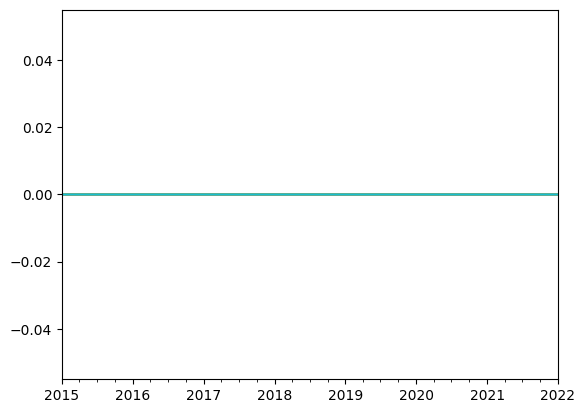

In [10]:
daily_shifts.plot(legend=False)

<Axes: >

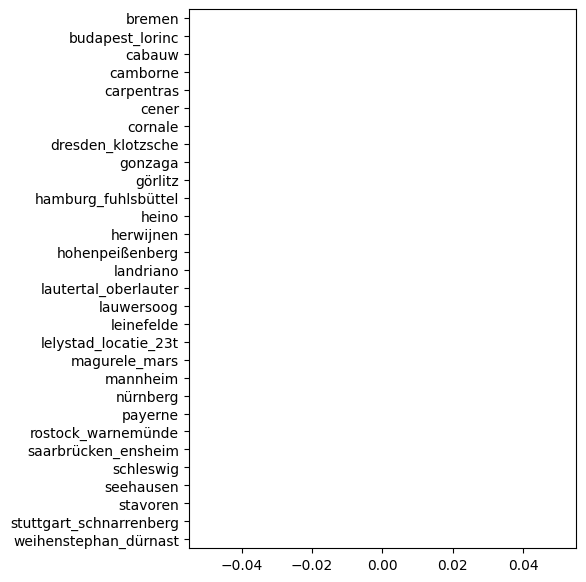

In [11]:
daily_shifts.mean().sort_index(ascending=False).plot.barh(figsize=(5,7))

=> no daily shift.

### export

In [12]:
model_hourly.to_csv(os.path.join(base_path, "parsed", "parsed_model_data_hourly.csv"))

## parse daily

### min max quality check

In [13]:
f"Minimum value: {model_daily.min().min()}"

'Minimum value: 0.0'

In [14]:
f"Maximum value: {model_daily.max().max()}"

'Maximum value: 8884.23'

=> Min and max values are in plausible range.

### remove 0.0-values

In [15]:
model_daily[model_daily <= 0].count().sort_values()[-10:]

badajoz                 0
grossenzersdorf         0
edinburgh             156
aberdeen_dyce_arpt    218
lund                  221
dunstaffnage          261
vaxjo_kronoberg       298
norrkoping            368
karlstad              412
stockholm             415
dtype: int64

In [16]:
model_daily = model_daily[model_daily > 0]

In [17]:
model_daily[model_daily <= 0].count().sort_values()[-10:]

albacete           0
huelva             0
salamanca          0
valencia_arpt      0
lleida             0
zaragoza_arpt      0
soria              0
arenosillo         0
leon_arpt          0
grossenzersdorf    0
dtype: int64

### export

In [18]:
model_daily.to_csv(os.path.join(base_path, "parsed", "parsed_model_data_daily.csv"))